#### TRAIN-----TransCoronalNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import copy
import time

class CoordAtt(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))  # 沿高度方向池化
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))  # 沿宽度方向池化
        
        mip = max(8, in_channels // reduction)
        
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.ReLU(inplace=True)
        
        self.conv_h = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        
        # 沿高度方向池化
        x_h = self.pool_h(x)  # [N, C, H, 1]
        # 沿宽度方向池化
        x_w = self.pool_w(x)  # [N, C, 1, W]
        
        # 变换尺寸
        x_h = x_h.permute(0, 1, 3, 2)  # [N, C, H, 1] -> [N, C, 1, H]
        
        # 进行拼接
        y = torch.cat([x_h, x_w], dim=3)  # [N, C, 1, H] + [N, C, 1, W] -> [N, C, 1, H+W]
        
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
        
        # 分割
        x_h, x_w = torch.split(y, [h, w], dim=3)
        
        x_h = self.conv_h(x_h.permute(0, 1, 3, 2))  # [N, C, 1, H] -> [N, C, H, 1]
        x_w = self.conv_w(x_w)  # [N, C, 1, W]
        
        a_h = x_h.sigmoid()
        a_w = x_w.sigmoid()
        
        out = identity * a_h * a_w
        
        return out

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class TransCoronalNet(nn.Module):
    def __init__(self):
        super(TransCoronalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.block1 = DepthwiseSeparableConv(32, 64)
        self.block2 = DepthwiseSeparableConv(64, 128, stride=2)
        self.block3 = DepthwiseSeparableConv(128, 256, stride=2)
        self.block4 = DepthwiseSeparableConv(256, 512, stride=2)

        self.coord_att = CoordAtt(512, 512)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.coord_att(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def get_dataloaders(data_dir, batch_size=32, num_workers=4):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    }

    image_datasets = {
        'train': datasets.ImageFolder(root=f'{data_dir}/train', transform=data_transforms['train']),
        'val': datasets.ImageFolder(root=f'{data_dir}/val', transform=data_transforms['val'])
    }

    dataloaders = {
        'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, dataset_sizes, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 更新最佳模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/TransCoronalNet_best.pth')

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch} completed in {epoch_time:.0f} seconds\n')

    print(f'Best val Acc: {best_acc:4f}')

    # 保存最好的模型
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/TransCoronalNet_best.pth')

    return model

# 设置设备和超参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/TrainSet_TransCoronalNet'

batch_size = 32
learning_rate = 0.001
num_epochs = 12
step_size = 7
gamma = 0.1

# 加载数据
dataloaders, dataset_sizes, class_names = get_dataloaders(data_dir, batch_size)

# 初始化模型、损失函数、优化器和学习率调度器
model = TransCoronalNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# 训练模型
model = train_model(model, dataloaders, criterion, optimizer, scheduler, device, dataset_sizes, num_epochs=num_epochs)

# 保存最后的模型
torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/TransCoronalNet_last.pth')


Epoch 0/11
----------
train Loss: 0.3827 Acc: 0.8702
val Loss: 0.1629 Acc: 1.0000
Epoch 0 completed in 19 seconds

Epoch 1/11
----------
train Loss: 0.1127 Acc: 0.9623
val Loss: 0.4712 Acc: 0.8045
Epoch 1 completed in 29 seconds

Epoch 2/11
----------
train Loss: 0.0596 Acc: 0.9864
val Loss: 0.0080 Acc: 1.0000
Epoch 2 completed in 32 seconds

Epoch 3/11
----------
train Loss: 0.0387 Acc: 0.9888
val Loss: 0.0163 Acc: 0.9936
Epoch 3 completed in 36 seconds

Epoch 4/11
----------
train Loss: 0.0582 Acc: 0.9816
val Loss: 0.0102 Acc: 1.0000
Epoch 4 completed in 29 seconds

Epoch 5/11
----------
train Loss: 0.0438 Acc: 0.9864
val Loss: 0.0016 Acc: 1.0000
Epoch 5 completed in 35 seconds

Epoch 6/11
----------
train Loss: 0.0412 Acc: 0.9856
val Loss: 0.0017 Acc: 1.0000
Epoch 6 completed in 30 seconds

Epoch 7/11
----------
train Loss: 0.0239 Acc: 0.9928
val Loss: 0.0014 Acc: 1.0000
Epoch 7 completed in 42 seconds

Epoch 8/11
----------
train Loss: 0.0239 Acc: 0.9928
val Loss: 0.0010 Acc: 1.000

#### TEST-----TransCoronalNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import copy
import time

class CoordAtt(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))  # 沿高度方向池化
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))  # 沿宽度方向池化
        
        mip = max(8, in_channels // reduction)
        
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.ReLU(inplace=True)
        
        self.conv_h = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        
        # 沿高度方向池化
        x_h = self.pool_h(x)  # [N, C, H, 1]
        # 沿宽度方向池化
        x_w = self.pool_w(x)  # [N, C, 1, W]
        
        # 变换尺寸
        x_h = x_h.permute(0, 1, 3, 2)  # [N, C, H, 1] -> [N, C, 1, H]
        
        # 进行拼接
        y = torch.cat([x_h, x_w], dim=3)  # [N, C, 1, H] + [N, C, 1, W] -> [N, C, 1, H+W]
        
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
        
        # 分割
        x_h, x_w = torch.split(y, [h, w], dim=3)
        
        x_h = self.conv_h(x_h.permute(0, 1, 3, 2))  # [N, C, 1, H] -> [N, C, H, 1]
        x_w = self.conv_w(x_w)  # [N, C, 1, W]
        
        a_h = x_h.sigmoid()
        a_w = x_w.sigmoid()
        
        out = identity * a_h * a_w
        
        return out

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class TransCoronalNet(nn.Module):
    def __init__(self):
        super(TransCoronalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.block1 = DepthwiseSeparableConv(32, 64)
        self.block2 = DepthwiseSeparableConv(64, 128, stride=2)
        self.block3 = DepthwiseSeparableConv(128, 256, stride=2)
        self.block4 = DepthwiseSeparableConv(256, 512, stride=2)

        self.coord_att = CoordAtt(512, 512)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.coord_att(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Test Accuracy: 1.0000
Total time to predict the dataset: 0.7190 seconds
Average time per image: 0.000264 seconds
Confusion Matrix:
[[1028    0]
 [   0 1692]]


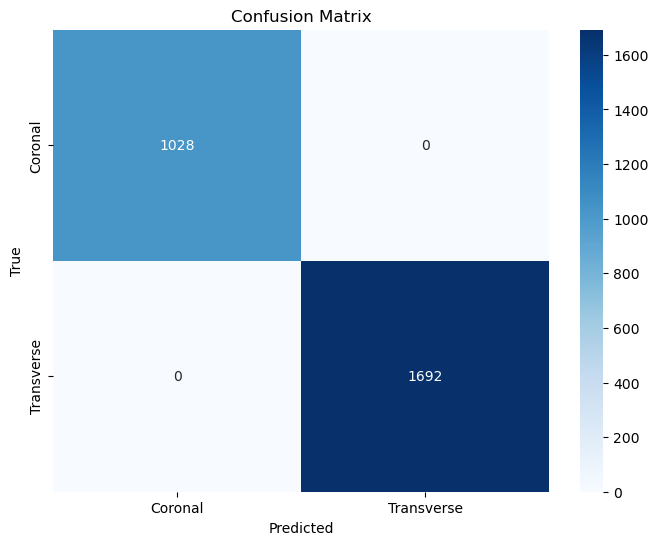

In [ ]:

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 加载已经训练好的模型权重
def load_model(model_path, device):
    model = TransCoronalNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# 数据加载和预处理
def get_test_dataloader(data_dir, batch_size=32, num_workers=4):
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

    dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_size = len(image_dataset)
    class_names = image_dataset.classes

    return dataloader, dataset_size, class_names

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 模型测试函数
def test_model(model, dataloader, device, dataset_size, class_names):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []

    total_time = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            start_time = time.time()  # Start time for each batch
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            batch_time = time.time() - start_time  # Calculate batch time
            total_time += batch_time
            num_batches += len(inputs)
            
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = running_corrects.double() / dataset_size
    print(f'Test Accuracy: {accuracy:.4f}')

    # Calculate and print latency metrics
    avg_time_per_image = total_time / num_batches
    print(f'Total time to predict the dataset: {total_time:.4f} seconds')
    print(f'Average time per image: {avg_time_per_image:.6f} seconds')

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:')
    print(cm)

    # 绘制混淆矩阵
    plot_confusion_matrix(cm, class_names)

# 设置设备和参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_data_dir = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Test_set/TestSet_TransCoronalNet'
model_path = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/TransCoronalNet_best.pth'
batch_size = 32

# 加载测试数据
test_dataloader, test_dataset_size, test_class_names = get_test_dataloader(test_data_dir, batch_size)

# 加载模型
model = load_model(model_path, device)

# 测试模型
test_model(model, test_dataloader, device, test_dataset_size, test_class_names)
